In [187]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x

    def __len__(self):
        return len(self.data) - self.window

In [211]:
input_size = 150
pred = input_size
learning_rate = 0.0001

data_size  = 6000
step = 1
m = 100 #на сколько шагов предсказать
data_set = 7000

In [189]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1))[:,:,:-1].permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

In [190]:
class DLinearModel(nn.Module):
    def __init__(self, input_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, 1)
        self.linear_trend = nn.Linear(input_size, 1)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()


In [191]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data['HUFL'].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [192]:
model = DLinearModel(input_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [193]:
len(dataloader)

5850

In [194]:
train_model(model, dataloader, criterion, optimizer)


Epoch =  0


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([1, 150, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
Epoch =  50
Epoch =  51
Epoch =  52
Epoch =  53
Epoch =  54
Epoch =  55
Epoch =  56
Epoch =  57
Epoch =  58
Epoch =  59
Epoch =  60
Epoch =  61
Epoch =  62
Epoch =  63
Epoch =  64
Epoch =  65
Epoch =  66
Epoch =  67
Epoch =  68
Epoch =  69
Epoch =  70
Epoch =  71
Epoch =  72
Epoch =  73
Epoch =  74
Epoch =  75
Epoch =  76
Epoch =  77
Epoch =  78
Epoch =  79
Epoch =  80
Epoch =  81
Epoch =  82
Epoch =  83
Epoch =  84
E

In [195]:
torch.save(model.state_dict(), "test_model_v8_SL1")

In [196]:
model.load_state_dict(torch.load("test_model_v8_SL1"))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)

In [197]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)>

In [198]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [212]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data['HUFL'].values[data_set-pred:data_set:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[ -5.6930],
        [-16.1420],
        [-14.7360],
        [-13.5300],
        [-13.0610],
        [-10.1140],
        [ -5.1570],
        [  2.4780],
        [  6.3630],
        [  7.4350],
        [  7.5690],
        [  7.5020],
        [  7.7700],
        [  7.9040],
        [ 12.6590],
        [  9.6450],
        [ 10.9180],
        [ 12.3240],
        [ 10.5160],
        [ 11.7210],
        [ 13.5300],
        [ 10.1140],
        [  2.2770],
        [ -6.8990],
        [-10.5160],
        [-13.5970],
        [-16.6780],
        [-10.5830],
        [-12.7260],
        [ -8.8410],
        [ -5.0230],
        [  2.0090],
        [  5.8270],
        [  6.8320],
        [  7.2340],
        [  6.2290],
        [  5.8940],
        [  8.1050],
        [ 10.7840],
        [ 10.2480],
        [  9.0420],
        [  9.6450],
        [  9.6450],
        [ 11.5210],
        [ 11.8550],
        [  6.0280],
        [  1.9420],
        [ -8.1050],
        [-11.4540],
        [-14.2000],


tensor([[ -5.6930],
        [-16.1420],
        [-14.7360],
        [-13.5300],
        [-13.0610],
        [-10.1140],
        [ -5.1570],
        [  2.4780],
        [  6.3630],
        [  7.4350],
        [  7.5690],
        [  7.5020],
        [  7.7700],
        [  7.9040],
        [ 12.6590],
        [  9.6450],
        [ 10.9180],
        [ 12.3240],
        [ 10.5160],
        [ 11.7210],
        [ 13.5300],
        [ 10.1140],
        [  2.2770],
        [ -6.8990],
        [-10.5160],
        [-13.5970],
        [-16.6780],
        [-10.5830],
        [-12.7260],
        [ -8.8410],
        [ -5.0230],
        [  2.0090],
        [  5.8270],
        [  6.8320],
        [  7.2340],
        [  6.2290],
        [  5.8940],
        [  8.1050],
        [ 10.7840],
        [ 10.2480],
        [  9.0420],
        [  9.6450],
        [  9.6450],
        [ 11.5210],
        [ 11.8550],
        [  6.0280],
        [  1.9420],
        [ -8.1050],
        [-11.4540],
        [-14.2000],


In [213]:
X_t = X_f.tolist()
X_t

[[-5.692999839782715],
 [-16.142000198364258],
 [-14.736000061035156],
 [-13.529999732971191],
 [-13.060999870300293],
 [-10.11400032043457],
 [-5.1570000648498535],
 [2.4779999256134033],
 [6.36299991607666],
 [7.434999942779541],
 [7.568999767303467],
 [7.501999855041504],
 [7.769999980926514],
 [7.9039998054504395],
 [12.659000396728516],
 [9.645000457763672],
 [10.918000221252441],
 [12.324000358581543],
 [10.515999794006348],
 [11.720999717712402],
 [13.529999732971191],
 [10.11400032043457],
 [2.2769999504089355],
 [-6.89900016784668],
 [-10.515999794006348],
 [-13.597000122070312],
 [-16.67799949645996],
 [-10.583000183105469],
 [-12.72599983215332],
 [-8.840999603271484],
 [-5.0229997634887695],
 [2.009000062942505],
 [5.827000141143799],
 [6.831999778747559],
 [7.234000205993652],
 [6.229000091552734],
 [5.894000053405762],
 [8.104999542236328],
 [10.784000396728516],
 [10.248000144958496],
 [9.041999816894531],
 [9.645000457763672],
 [9.645000457763672],
 [11.520999908447266]

In [214]:

predicted_values = []



for i in range(m):
    
    
    #проверить что модель принимает нужный набор значений
    #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    
    
    
    
    X = torch.tensor([X_t])
    print(X)
    prediction = model(X)
    predicted_values.append(prediction.tolist()[-1][-1][-1])
    X_next = prediction.tolist()[-1][-1]
    
    X_t.append(X_next)
    X_t = X_t[1:]
    dataset_f = MyDataset(X_t, window_size)
        
    


future_predictions = predicted_values

tensor([[[ -5.6930],
         [-16.1420],
         [-14.7360],
         [-13.5300],
         [-13.0610],
         [-10.1140],
         [ -5.1570],
         [  2.4780],
         [  6.3630],
         [  7.4350],
         [  7.5690],
         [  7.5020],
         [  7.7700],
         [  7.9040],
         [ 12.6590],
         [  9.6450],
         [ 10.9180],
         [ 12.3240],
         [ 10.5160],
         [ 11.7210],
         [ 13.5300],
         [ 10.1140],
         [  2.2770],
         [ -6.8990],
         [-10.5160],
         [-13.5970],
         [-16.6780],
         [-10.5830],
         [-12.7260],
         [ -8.8410],
         [ -5.0230],
         [  2.0090],
         [  5.8270],
         [  6.8320],
         [  7.2340],
         [  6.2290],
         [  5.8940],
         [  8.1050],
         [ 10.7840],
         [ 10.2480],
         [  9.0420],
         [  9.6450],
         [  9.6450],
         [ 11.5210],
         [ 11.8550],
         [  6.0280],
         [  1.9420],
         [ -8

In [215]:
future_predictions

[2.599093198776245,
 2.324723958969116,
 2.613746404647827,
 2.620647668838501,
 2.605062961578369,
 2.570612907409668,
 2.602539300918579,
 2.8501808643341064,
 2.9524383544921875,
 2.978440761566162,
 2.999250888824463,
 3.0050036907196045,
 2.972991466522217,
 2.9062657356262207,
 3.02486515045166,
 2.776179075241089,
 2.7905163764953613,
 2.799043655395508,
 2.6206297874450684,
 2.576882839202881,
 2.6228535175323486,
 2.481863260269165,
 2.258584499359131,
 2.094949722290039,
 2.165992259979248,
 2.2787461280822754,
 2.3595800399780273,
 2.7738029956817627,
 2.6472058296203613,
 2.7337911128997803,
 2.7318668365478516,
 2.9539356231689453,
 3.0433499813079834,
 3.0377135276794434,
 3.0503647327423096,
 2.9977102279663086,
 2.940074920654297,
 3.005171775817871,
 3.0079586505889893,
 2.8955395221710205,
 2.7422423362731934,
 2.724571943283081,
 2.6580214500427246,
 2.697322368621826,
 2.6505086421966553,
 2.3991241455078125,
 2.425706624984741,
 2.157855987548828,
 2.25641465187072

In [216]:
len(future_predictions)

100

Future Predictions: [2.599093198776245, 2.324723958969116, 2.613746404647827, 2.620647668838501, 2.605062961578369, 2.570612907409668, 2.602539300918579, 2.8501808643341064, 2.9524383544921875, 2.978440761566162, 2.999250888824463, 3.0050036907196045, 2.972991466522217, 2.9062657356262207, 3.02486515045166, 2.776179075241089, 2.7905163764953613, 2.799043655395508, 2.6206297874450684, 2.576882839202881, 2.6228535175323486, 2.481863260269165, 2.258584499359131, 2.094949722290039, 2.165992259979248, 2.2787461280822754, 2.3595800399780273, 2.7738029956817627, 2.6472058296203613, 2.7337911128997803, 2.7318668365478516, 2.9539356231689453, 3.0433499813079834, 3.0377135276794434, 3.0503647327423096, 2.9977102279663086, 2.940074920654297, 3.005171775817871, 3.0079586505889893, 2.8955395221710205, 2.7422423362731934, 2.724571943283081, 2.6580214500427246, 2.697322368621826, 2.6505086421966553, 2.3991241455078125, 2.425706624984741, 2.157855987548828, 2.2564146518707275, 2.3710060119628906, 2.40

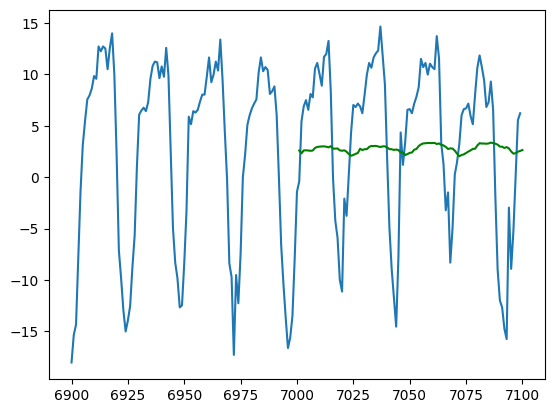

<Figure size 640x480 with 0 Axes>

In [217]:
print("Future Predictions:", future_predictions)
time = [data_set-m+i for i in range(2*m)]
plt.plot(time, data['HUFL'].values[data_set-m:data_set+m:step])
#plt.plot(, )
pred = data['HUFL'].values[data_set-1]
time = [data_set+1+i for i in range(m)]

    
plt.plot(time, future_predictions, 'g-')

plt.show()
plt.savefig("forecast", dpi=200)


